### Real Time Data Simulator from Historical Data

This project aims to simulate the streaming of real time data given a historical data source. Currently, we have trade-level data available, meaning we have every trade for a year of ES futures, but we are missing the bid ask prices that those trades were executed under. We only have the trade price itself. 

Our trading strategies operate at 4 ticks per second, meaning we will need to control the sampling speed of the data to miss events that happen between sampling periods. However, we want to be able to control the playback speed, such that even though we sample the last price 4x per second, we should be able to speed up playback speed decoupled from the realtime speed.

We also want to handle slippage under various parameters. One way to do that is to simulate each of our trades happening at one tick-size worse than we anticipated by the strategy. Then the strategy can account for this by waiting until 1 tick more than desired has happened. 

### Development Strategy
Given a set of realtime trades and their time stamps, sample the price every 4 seconds. 
Run each sample through the running strategy. Visualize the strategy


In [5]:
%pip install seaborn

DEPRECATION: Loading egg at /opt/miniconda3/envs/ibkr/lib/python3.12/site-packages/ibapi-10.19.4-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


           time    price  volume symbol
0  1.702651e+09  4768.25    16.0   ESH4
1  1.702651e+09  4768.25     3.0   ESH4
2  1.702651e+09  4768.25     1.0   ESH4
3  1.702651e+09  4768.25     2.0   ESH4
4  1.702651e+09  4768.25     2.0   ESH4


/var/folders/k1/8prjln590qxc6f3c26mf_f100000gn/T/ipykernel_12761/2404159731.py:191: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  resampled_data = data['price'].resample('250L').last().fillna(method='ffill').dropna().reset_index()
/var/folders/k1/8prjln590qxc6f3c26mf_f100000gn/T/ipykernel_12761/2404159731.py:191: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled_data = data['price'].resample('250L').last().fillna(method='ffill').dropna().reset_index()
/var/folders/k1/8prjln590qxc6f3c26mf_f100000gn/T/ipykernel_12761/2404159731.py:161: UserWarning: frames=<map object at 0x1295efa00> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX

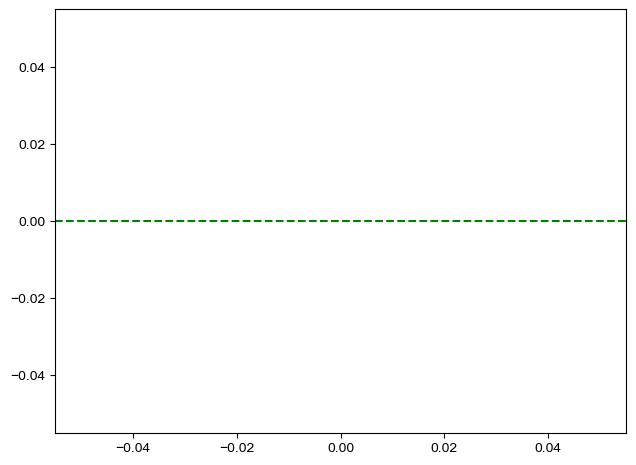

/opt/miniconda3/envs/ibkr/lib/python3.12/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import matplotlib.animation as animation

# Define the App class that interacts with the strategy
class App:
    def __init__(self, tick_size=0.25, trade_cost=0.0):
        self.tick_size = tick_size
        self.trade_cost = trade_cost
        self.last_price = None
        self.qty = 0  # Position quantity: 0 (flat), 1 (long), -1 (short)
        self.open_price = None
        self.total_profit = 0.0
        self.current_profit = 0.0

    def tickPrice(self, price):
        self.last_price = price

    def calculate_current_profit(self):
        if self.qty != 0:
            self.current_profit = (self.last_price - self.open_price) * self.qty - self.trade_cost
        else:
            self.current_profit = 0.0

    def open_long_position(self):
        self.qty = 1
        self.open_price = self.last_price + self.tick_size  # Simulate slippage
        self.calculate_current_profit()

    def close_long_position(self):
        profit = (self.last_price - self.open_price) * self.qty - self.trade_cost
        self.total_profit += profit
        self.qty = 0
        self.open_price = None
        self.current_profit = 0.0

    def open_short_position(self):
        self.qty = -1
        self.open_price = self.last_price - self.tick_size  # Simulate slippage
        self.calculate_current_profit()

    def close_short_position(self):
        profit = (self.open_price - self.last_price) * -self.qty - self.trade_cost
        self.total_profit += profit
        self.qty = 0
        self.open_price = None
        self.current_profit = 0.0

# Define the Mean Reversion Strategy
class MeanReversionStrategy:
    def __init__(self, app, boll_window=600, width=2):
        self.app = app
        self.boll_window = boll_window
        self.width = width
        self.prices = deque(maxlen=boll_window)
        
    def tick(self, price):
        self.app.tickPrice(price)
        self.prices.append(self.app.last_price)
        self.app.calculate_current_profit()
        
        if len(self.prices) == self.boll_window:
            mu = np.mean(self.prices)
            std = np.std(self.prices)
            upper_band = mu + self.width * std
            lower_band = mu - self.width * std
            
            if self.app.qty == 0:
                if self.app.last_price < lower_band - self.app.tick_size:
                    self.app.open_long_position()
                elif self.app.last_price > upper_band + self.app.tick_size:
                    self.app.open_short_position()
            elif self.app.qty == 1:
                if self.app.last_price >= mu:
                    self.app.close_long_position()
            elif self.app.qty == -1:
                if self.app.last_price <= mu:
                    self.app.close_short_position()

# Define the Backtester class
class Backtester:
    def __init__(self, data, strategy, sampling_interval=0.25, speed=1.0):
        self.data = data
        self.strategy = strategy
        self.sampling_interval = sampling_interval  # Interval in seconds
        self.speed = speed  # Playback speed
        self.price_history = []
        self.upper_bands = []
        self.lower_bands = []
        self.sma = []
        self.timestamps = []

    def run(self, plotting=True):
        if plotting:
            fig, ax = plt.subplots()
            plt.style.use('seaborn-v0_8-darkgrid')
            plt.tight_layout()
            line_price, = ax.plot([], [], label="Price", color="blue")
            line_upper, = ax.plot([], [], label="Upper Band", color="purple")
            line_lower, = ax.plot([], [], label="Lower Band", color="purple")
            line_sma, = ax.plot([], [], label="SMA", color="cornflowerblue")
            text_pnl = ax.text(0.02, 0.95, '', transform=ax.transAxes)
            text_std = ax.text(0.02, 0.90, '', transform=ax.transAxes)
            text_current_profit = ax.text(0.02, 0.85, '', transform=ax.transAxes)
            line_open_price = ax.axhline(y=0, color='green', linestyle='--', label='Open Price')

            def init():
                ax.set_xlim(0, self.strategy.boll_window)
                ax.set_ylim(min(self.data['price']), max(self.data['price']))
                return line_price, line_upper, line_lower, line_sma, text_pnl, text_std, text_current_profit, line_open_price

            def update(frame):
                price = frame['price']
                timestamp = frame['datetime']
                self.strategy.tick(price)
                self.price_history.append(price)
                self.timestamps.append(timestamp)

                if len(self.strategy.prices) == self.strategy.boll_window:
                    mu = np.mean(self.strategy.prices)
                    std = np.std(self.strategy.prices)
                    upper_band = mu + self.strategy.width * std
                    lower_band = mu - self.strategy.width * std
                    self.upper_bands.append(upper_band)
                    self.lower_bands.append(lower_band)
                    self.sma.append(mu)
                else:
                    self.upper_bands.append(None)
                    self.lower_bands.append(None)
                    self.sma.append(None)

                x_axis = range(len(self.price_history))

                line_price.set_data(x_axis, self.price_history)
                line_upper.set_data(x_axis, self.upper_bands)
                line_lower.set_data(x_axis, self.lower_bands)
                line_sma.set_data(x_axis, self.sma)
                ax.relim()
                ax.autoscale_view()

                text_pnl.set_text(f'Total PnL: {self.strategy.app.total_profit:.2f}')
                if len(self.strategy.prices) == self.strategy.boll_window:
                    text_std.set_text(f'Std: {std:.2f}')
                else:
                    text_std.set_text('Std: Calculating...')

                if self.strategy.app.qty != 0:
                    text_current_profit.set_text(f'Current Profit: {self.strategy.app.current_profit:.2f}')
                    line_open_price.set_ydata(self.strategy.app.open_price)
                    line_open_price.set_visible(True)
                else:
                    text_current_profit.set_text('Current Profit: 0.00')
                    line_open_price.set_visible(False)

                ax.legend(loc="upper left")

                return line_price, line_upper, line_lower, line_sma, text_pnl, text_std, text_current_profit, line_open_price

            ani = animation.FuncAnimation(
                fig,
                update,
                frames=self.data.itertuples(index=False),
                init_func=init,
                interval=(self.sampling_interval / self.speed) * 1000,
                blit=False,
                repeat=False
            )
            plt.show()
        else:
            # Run without plotting (e.g., for performance testing)
            for index, row in self.data.iterrows():
                price = row['price']
                self.strategy.tick(price)

# Load and preprocess data
# Replace 'your_data.csv' with the path to your CSV file
# The CSV should have columns: time, price, volume, symbol
csv = r"/Users/dan/Documents/Finance/Programs/Financial Machine Learning/Backtesting/ES-Trades-During-Market-Hours.csv"
data = pd.read_csv(csv, names=['time', 'price', 'volume', 'symbol'], header=0)
print(data.head())

# Convert 'time' to datetime
data['datetime'] = pd.to_datetime(data['time'], unit='s')

# Set datetime as index
data.set_index('datetime', inplace=True)

# Resample data at 0.25-second intervals using the last price available
resampled_data = data['price'].resample('250L').last().fillna(method='ffill').dropna().reset_index()

# Initialize App and Strategy
app = App()
strategy = MeanReversionStrategy(app)

# Initialize Backtester with desired speed (e.g., speed=10 for 10x faster playback)
backtester = Backtester(resampled_data, strategy, sampling_interval=0.25, speed=1.0)

# Run Backtester
backtester.run()